### Imports

In [21]:
import pickle as pkl
import xarray as xr
import numpy as np
import os
from matplotlib import pyplot as plt

from math import radians, cos, sin, asin, sqrt
from multiprocessing import Pool
from time import time

### Constants

In [2]:
ADDRESSdata = '/mnt/data/bhendj/full/cosmo-1'  # COSMO-1 outputs
ADDRESStopo = '/mnt/ds3lab-scratch/ninow/topo'  # base address of topo files
ADDRESSobst = '/mnt/ds3lab-scratch/ninow/observations'  # base adress of obs files
DESTINATION = '/mnt/ds3lab-scratch/ninow/preprocessed_data/knn_regression/knn_5'

# create output folder
if not os.path.exists(DESTINATION + "/temp"):
    os.makedirs(DESTINATION + "/temp")
    
# K for K-NN
K = 10
n_parallel = 16
Leads = range(34)

### Get all files and observations

In [3]:
# load data
OBS = xr.open_dataset(ADDRESSobst + '/meteoswiss_t2m_20151001-20180331.nc')
TOPO = xr.open_dataset(ADDRESStopo + '/topodata.nc')
# get all stations
station_ids = OBS['station_id'].data
# get all COSMO-1 files
all_files = sorted([(D[-12:-4], D[-4:]) for D in os.listdir(ADDRESSdata) if D[0] == '1' and D[-4] == '_'])

### Define Haversine to calculate distance

In [5]:
# source: https://stackoverflow.com/questions/15736995/how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
# date: 11.04.2018
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers is 6371
    m = 6371* 1000 * c
    return m

### Calculate closest k-grid points per station

In [6]:
def calculate_k_neighbors(station, gridLatData, gridLonData, station_lat, station_lon):
    # calculate horizontal distance in meters
    grid_lat_lon_zip = np.array(list(zip(
        gridLatData.ravel(), gridLonData.ravel())), dtype=('float32,float32')) \
        .reshape(gridLatData.shape)
    gridHorizontalDistance = np.vectorize(
        lambda lat_lon_zip: haversine(lat_lon_zip[0], lat_lon_zip[1], station_lat, station_lon))(
        grid_lat_lon_zip).flatten()

    idx = np.argpartition(gridHorizontalDistance, K)[:K]
    return station, list(zip(*np.unravel_index(idx,(674,1058))))

In [7]:
# load existing k neighbor information per station, otherwise calculate and dump neighborhoods 
if os.path.exists(DESTINATION +  '/station_%s_neighbors.pkl' % K):
    with open(DESTINATION +  '/station_%s_neighbors.pkl' % K, 'rb') as handle:
        station_k_neighbors = pkl.load(file=handle)
    
else:
    # get lat/lon on grid
    gridLatData = TOPO.lat.data
    gridLonData = TOPO.lon.data

    # dictionary with closest K points per stations
    station_k_neighbors = {}

    # calculate for each station the neighbors on the grid in parallel
    with Pool(processes=16) as pool:
        process_results = []

        for station in station_ids:
            # get lat/lon for station
            station_lat = OBS['lat'].sel(station_id=station).data
            station_lon = OBS['lon'].sel(station_id=station).data

            process_results.append(pool.apply_async(calculate_k_neighbors, (station, gridLatData, gridLonData,
                                                                            station_lat, station_lon)))

        # aggregate results from all processes
        for ps_idx, ps_result in enumerate(process_results):
            # sync processes
            S, k_neighbors = ps_result.get()
            station_k_neighbors[S] = k_neighbors
    with open(DESTINATION +  '/station_%s_neighbors.pkl' % K, 'wb') as handle:
        pkl.dump(file=handle, obj=station_k_neighbors)

### Calculate k-NN error

In [10]:
# this exception is used to break innter loop and continue outer loop with next iteration
class SkipException(Exception):
    pass

def calculate_error_per_lead(processId, process_obs_path, data_split):
    OBS = xr.open_dataset(process_obs_path)
    # generate a view on temperature observation at each station
    TempObs = OBS['t2m']
    n_files = len(data_split)
    # we now start the iteration through: Each folder, each file, each parameter, each station
    error_per_lead = {}
    data_load_times = []
    work_times = []
    for file_idx, file in enumerate(data_split):  # loop over all  outputs of COSMO-1, e.g. for 3h interval every day
        try:
            # mark start of preprocessing of n-th file
            print('Start processing %s' % file[0])

            for idx_T, T in enumerate(Leads):  # loop over all future predictions, e.g. current hour + T

                if T < 10:
                    NAME = ADDRESSdata + '/' + file[0] + file[1] + '/c1ffsurf00' + str(T) + '.nc'
                else:
                    NAME = ADDRESSdata + '/' + file[0] + file[1] + '/c1ffsurf0' + str(T) + '.nc'
                before_data_load = time()
                # load netCRF4 dataset
                dataset = xr.open_dataset(NAME)
                
                after_data_load = time()

                # get initialization time of COSMO-1 data point
                t = dataset['time'].data

                # check that we do not process a data point before the first observation
                if t < OBS['time'].data[0]:
                    print('[Process %s] Skipped %s' % (processId, file))
                    raise SkipException()

                Target = TempObs.sel(time = t).data.squeeze()

                MAP = dataset['T'].data.squeeze()
                for idx_S, S in enumerate(station_ids):
                    stationSquare = station_k_neighbors[S]
                    lat, lon = list(zip(*stationSquare))
                    station_prediction = np.mean(MAP[lat,lon]) - 273.15
                    station_error = station_prediction - Target[idx_S]
                    if station_error >= 15:
                        print(S, t, lat, lon, station_prediction, Target[idx_S], station_error)
                    try:
                        error_per_lead[T] += [station_error]
                    except KeyError:
                        error_per_lead[T] = [station_error]

                # this dataset is not used anymore and can be closed
                dataset.close()
                
                after_lead = time()
                data_load_times += [after_data_load - before_data_load]
                work_times += [after_lead - after_data_load]
            print('[Process %s] File %s (Progess: %2.f%%)' % (processId, file_idx, ((file_idx+1)/n_files)*100))
        except SkipException:
            continue
    with open(DESTINATION +  '/temp/process_%s_error_data.pkl' % processId, 'wb') as handle:
        pkl.dump(file=handle, obj=error_per_lead)
    print("Avg. Times: Data loading=%s, Work=%s" % (np.mean(data_load_times), np.mean(work_times)))
    OBS.close()
    return 0

In [11]:
# load train / test split used for other baselines
train_test_splits = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/train_test_folds_r_3_sl_24_tfw_66_tf_0.1_series_0_s_23021.pkl','rb'))

for run_idx, train_test_split in enumerate(train_test_splits):
    start_time=time()
    # get all inits for the current test split
    current_split = set([item[1] for item in train_test_splits[run_idx][1]])
    # filter files to only keep the current test files
    split_files = [init for init in all_files if init[0] in current_split]
    n_files = len(split_files)
    # split files into 16 chunks to be processed in parallel
    indices = np.linspace(0, n_files, n_parallel+1).astype(int)
    data_splits = [split_files[indices[i]:indices[i + 1]] for i in range(n_parallel)]

    all_errors_per_lead = {}
    with Pool(processes=n_parallel) as pool:
        process_results = []

        for ps_idx, data_split in enumerate(data_splits):
            process_obs_path = ADDRESSobst + '/process_%s/meteoswiss_t2m_20151001-20180331.nc' % ps_idx
            process_results.append(pool.apply_async(calculate_error_per_lead, (ps_idx, process_obs_path, data_split)))

        # aggregate results from all processes
        for ps_idx, ps_result in enumerate(process_results):
            # sync processes
            _ = ps_result.get()

            with open(DESTINATION +  '/temp/process_%s_error_data.pkl' % ps_idx, 'rb') as handle:
                error_data = pkl.load(handle)
            for lead, error_per_lead in error_data.items():
                try:
                    all_errors_per_lead[lead] += error_per_lead
                except KeyError:
                    all_errors_per_lead[lead] = error_per_lead
            print("[Process %s] Result been aggregated." % ps_idx)
    for lead, error_per_lead in all_errors_per_lead.items():
        print('Lead %s:' % lead, np.sqrt(np.nanmean(np.square(error_per_lead))))
    end_time = time()
    total_time = (end_time - start_time)
    print('Run took: %ss' % total_time)
    
    with open(DESTINATION +  '/knn_errors_per_lead_run_%s.pkl' % run_idx, 'wb') as handle:
        pkl.dump(file=handle, obj=all_errors_per_lead)

Start processing 16052906
Start processing 15100103
Start processing 17090521
Start processing 15102718
Start processing 17040709
Start processing 16091303
Start processing 16070321
Start processing 16020300
Start processing 15121409
Start processing 16081112
Start processing 16040515
Start processing 17052415
Start processing 16103018
Start processing 17051300
Start processing 17081906
Start processing 17111012
[Process 15] File 0 (Progess:  2%)
Start processing 17111015
[Process 12] File 0 (Progess:  2%)
Start processing 17052418
[Process 2] File 0 (Progess:  2%)
Start processing 15121412
[Process 1] File 0 (Progess:  2%)
Start processing 15102721
[Process 0] File 0 (Progess:  2%)
Start processing 15100106
[Process 4] File 0 (Progess:  2%)
Start processing 16040518
[Process 3] File 0 (Progess:  2%)
Start processing 16020303
[Process 5] File 0 (Progess:  2%)
Start processing 16052909
[Process 7] File 0 (Progess:  2%)
Start processing 16081115
[Process 11] File 0 (Progess:  2%)
Start p

Start processing 17090615
[Process 15] File 8 (Progess: 20%)
Start processing 17111115
[Process 9] File 5 (Progess: 13%)
Start processing 16110612
[Process 5] File 5 (Progess: 13%)
Start processing 16053000
[Process 13] File 5 (Progess: 13%)
Start processing 17082000
[Process 6] File 5 (Progess: 13%)
Start processing 16070415
[Process 8] File 5 (Progess: 13%)
Start processing 16091321
852 ['2016-01-17T23:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.837225341796852 -26.5 16.662774658203148
852 ['2016-01-18T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.643408203124977 -25.1 15.45659217834475
852 ['2016-01-18T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.929785156249977 -27.6 17.67021522521975
852 ['2016-01-18T02:00:00.000000000'] (392, 393, 393, 394, 393

Start processing 17051406
[Process 7] File 9 (Progess: 22%)
Start processing 16081218
[Process 14] File 9 (Progess: 22%)
Start processing 17090703
[Process 10] File 9 (Progess: 22%)
Start processing 17041415
[Process 0] File 14 (Progess: 33%)
Start processing 15100300
[Process 13] File 9 (Progess: 22%)
Start processing 17082012
[Process 6] File 9 (Progess: 22%)
Start processing 16070503
[Process 12] File 14 (Progess: 33%)
Start processing 17070412
[Process 8] File 9 (Progess: 22%)
Start processing 16091409
[Process 9] File 9 (Progess: 22%)
Start processing 16110700
[Process 5] File 9 (Progess: 22%)
Start processing 16053012
[Process 1] File 15 (Progess: 36%)
Start processing 15120418
[Process 15] File 14 (Progess: 33%)
Start processing 17111209
[Process 2] File 12 (Progess: 29%)
Start processing 16011800
852 ['2016-01-18T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.658483886718727 -25.1 15.441516494751
[Pr

Start processing 17123112
[Process 12] File 21 (Progess: 49%)
Start processing 17070509
[Process 6] File 16 (Progess: 38%)
Start processing 16070600
[Process 8] File 16 (Progess: 38%)
Start processing 16091506
[Process 7] File 16 (Progess: 38%)
Start processing 16081315
[Process 13] File 16 (Progess: 38%)
Start processing 17082109
[Process 9] File 16 (Progess: 38%)
Start processing 16110721
[Process 5] File 16 (Progess: 38%)
Start processing 16060309
[Process 2] File 19 (Progess: 44%)
Start processing 16011821
[Process 1] File 26 (Progess: 60%)
Start processing 15121203
[Process 3] File 17 (Progess: 40%)
Start processing 16031806
[Process 0] File 25 (Progess: 58%)
Start processing 15102509
[Process 4] File 17 (Progess: 40%)
Start processing 16042221
[Process 15] File 24 (Progess: 56%)
Start processing 17123115
[Process 14] File 17 (Progess: 40%)
Start processing 17092603
[Process 10] File 17 (Progess: 40%)
Start processing 17041515
[Process 11] File 17 (Progess: 40%)
Start processing 1

Start processing 15121312
[Process 0] File 36 (Progess: 82%)
Start processing 15102618
[Process 15] File 34 (Progess: 78%)
Start processing 18010121
[Process 10] File 24 (Progess: 56%)
Start processing 17041612
[Process 11] File 24 (Progess: 56%)
Start processing 17051603
[Process 14] File 24 (Progess: 56%)
Start processing 17092700
[Process 12] File 29 (Progess: 67%)
Start processing 17070609
[Process 13] File 24 (Progess: 56%)
Start processing 17082209
[Process 8] File 24 (Progess: 56%)
Start processing 16102806
[Process 6] File 24 (Progess: 56%)
Start processing 16072800
[Process 7] File 24 (Progess: 56%)
Start processing 16082915
[Process 2] File 27 (Progess: 62%)
Start processing 16011921
[Process 3] File 25 (Progess: 58%)
Start processing 16031906
[Process 1] File 38 (Progess: 87%)
Start processing 15121315
[Process 9] File 24 (Progess: 56%)
Start processing 16110821
[Process 4] File 25 (Progess: 58%)
Start processing 16042321
[Process 0] File 37 (Progess: 84%)
Start processing 1

[Process 5] File 31 (Progess: 71%)
Start processing 16060506
[Process 3] File 33 (Progess: 76%)
Start processing 16040406
[Process 11] File 32 (Progess: 73%)
Start processing 17052303
[Process 4] File 33 (Progess: 76%)
Start processing 16042421
[Process 13] File 32 (Progess: 73%)
Start processing 17082309
[Process 14] File 32 (Progess: 73%)
Start processing 17092800
[Process 8] File 32 (Progess: 73%)
Start processing 16102906
[Process 10] File 32 (Progess: 73%)
Start processing 17051112
[Process 2] File 35 (Progess: 80%)
Start processing 16020121
[Process 6] File 32 (Progess: 73%)
Start processing 16072900
[Process 7] File 32 (Progess: 73%)
Start processing 16083015
[Process 12] File 37 (Progess: 84%)
Start processing 17081809
[Process 9] File 32 (Progess: 73%)
Start processing 17040521
[Process 5] File 32 (Progess: 73%)
Start processing 16060509
[Process 3] File 34 (Progess: 78%)
Start processing 16040409
[Process 4] File 34 (Progess: 78%)
Start processing 16042500
[Process 11] File 3

Start processing 16040512
[Process 11] File 42 (Progess: 96%)
Start processing 17052409
[Process 8] File 42 (Progess: 96%)
Start processing 16103012
[Process 6] File 42 (Progess: 96%)
Start processing 16081106
[Process 13] File 42 (Progess: 96%)
Start processing 17090515
[Process 10] File 42 (Progess: 96%)
Start processing 17051218
[Process 14] File 43 (Progess: 98%)
Start processing 17111009
[Process 7] File 42 (Progess: 96%)
Start processing 16083121
[Process 9] File 42 (Progess: 96%)
Start processing 17040703
[Process 5] File 42 (Progess: 96%)
Start processing 16070315
[Process 3] File 44 (Progess: 100%)
Avg. Times: Data loading=11.793036202200097, Work=0.5548143505270964
[Process 3] Result been aggregated.
[Process 4] File 44 (Progess: 100%)
Avg. Times: Data loading=11.791559377059437, Work=0.5685434860341689
[Process 4] Result been aggregated.
[Process 11] File 43 (Progess: 98%)
Start processing 17052412
[Process 14] File 44 (Progess: 100%)
Avg. Times: Data loading=11.749673415009

852 ['2016-01-18T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -10.354498291015602 -27.6 17.245502090454124
852 ['2016-01-18T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -10.610266113281227 -25.7 15.089734649658226
[Process 2] File 2 (Progess:  7%)
Start processing 16050618
[Process 14] File 3 (Progess:  9%)
Start processing 17112009
[Process 1] File 2 (Progess:  7%)
Start processing 16030803
[Process 13] File 2 (Progess:  7%)
Start processing 17101815
[Process 5] File 2 (Progess:  7%)
Start processing 16112215
[Process 11] File 2 (Progess:  7%)
Start processing 17052209
[Process 7] File 2 (Progess:  7%)
Start processing 17012621
[Process 10] File 2 (Progess:  7%)
Start processing 17042218
[Process 8] File 2 (Progess:  7%)
Start processing 17022512
[Process 15] File 3 (Progess:  9%)
Start processing 18020300
[Process 4] File 2 (Proge

Start processing 18020321
[Process 12] File 9 (Progess: 22%)
Start processing 17091321
[Process 0] File 12 (Progess: 29%)
Start processing 15102318
[Process 2] File 9 (Progess: 22%)
Start processing 16050715
[Process 1] File 8 (Progess: 20%)
Start processing 16030821
[Process 14] File 11 (Progess: 27%)
Start processing 17112109
[Process 11] File 8 (Progess: 20%)
Start processing 17081203
[Process 5] File 8 (Progess: 20%)
Start processing 16112309
[Process 13] File 8 (Progess: 20%)
Start processing 17101909
[Process 7] File 8 (Progess: 20%)
Start processing 17012715
[Process 15] File 11 (Progess: 27%)
Start processing 18020400
852 ['2016-03-09T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -7.816137695312477 -23.7 15.883863067626976
[Process 3] File 8 (Progess: 20%)
Start processing 16072103
[Process 9] File 8 (Progess: 20%)
Start processing 17032121
[Process 8] File 8 (Progess: 20%)
Start processing 17022606
[P

Start processing 16101012
[Process 14] File 20 (Progess: 47%)
Start processing 17122812
[Process 1] File 15 (Progess: 36%)
Start processing 16030918
[Process 2] File 17 (Progess: 40%)
Start processing 16050815
[Process 15] File 20 (Progess: 47%)
Start processing 18022303
[Process 0] File 23 (Progess: 53%)
Start processing 16011403
[Process 3] File 15 (Progess: 36%)
Start processing 16072200
[Process 7] File 15 (Progess: 36%)
Start processing 17012812
[Process 9] File 15 (Progess: 36%)
Start processing 17032218
[Process 5] File 15 (Progess: 36%)
Start processing 16122406
[Process 8] File 15 (Progess: 36%)
Start processing 17022703
[Process 11] File 15 (Progess: 36%)
Start processing 17081300
[Process 13] File 15 (Progess: 36%)
Start processing 17110106
[Process 10] File 15 (Progess: 36%)
Start processing 17050609
[Process 12] File 17 (Progess: 40%)
Start processing 17092921
[Process 14] File 21 (Progess: 49%)
Start processing 17122815
[Process 6] File 15 (Progess: 36%)
Start processing 

[Process 1] File 19 (Progess: 44%)
Start processing 16031006
[Process 15] File 25 (Progess: 58%)
Start processing 18022318
852 ['2017-01-20T22:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.0927185058593523 -18.8 15.707280731201195
[Process 2] File 21 (Progess: 49%)
Start processing 16050903
852 ['2017-01-20T23:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.4965576171874773 -19.6 17.10344276428225
852 ['2017-01-21T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.3373168945312273 -18.4 16.062682723999046
[Process 0] File 27 (Progess: 62%)
Start processing 16011415
852 ['2017-01-21T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.1451171874999773 -20.2 18.054883575439476
852 ['2017-01-21

852 ['2017-01-21T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.4111389160156023 -20.2 17.78886184692385
852 ['2017-01-21T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.9396118164062273 -20.5 17.560388183593773
[Process 2] File 23 (Progess: 53%)
Start processing 16050909
852 ['2017-01-21T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.2970336914062273 -21.1 17.8029666900635
852 ['2017-01-21T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.7683471679687273 -21.0 18.231652832031273
[Process 15] File 28 (Progess: 64%)
Start processing 18022403
[Process 0] File 29 (Progess: 67%)
Start processing 16011421
852 ['2017-01-21T05:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 

Start processing 18022409
852 ['2017-01-22T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.4552062988281023 -21.1 17.644794082641624
[Process 6] File 22 (Progess: 51%)
Start processing 17012018
[Process 4] File 22 (Progess: 51%)
Start processing 16101112
852 ['2017-01-20T22:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.8155273437499773 -18.8 15.98447189331057
[Process 1] File 23 (Progess: 53%)
Start processing 16031018
852 ['2017-01-20T23:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.4243225097656023 -19.6 17.175677871704124
852 ['2017-01-21T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.6807006835937273 -18.4 15.719298934936546
852 ['2017-01-21T01:00:00.000000000'] (392, 393, 393

852 ['2017-01-21T11:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.29520263671872726 -17.0 16.704797363281273
[Process 15] File 32 (Progess: 73%)
Start processing 18022415
[Process 13] File 23 (Progess: 53%)
Start processing 17110206
852 ['2017-01-21T18:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.3984436035156023 -17.5 15.101556396484398
852 ['2017-01-21T19:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.3935913085937273 -18.4 16.006408309936546
[Process 9] File 24 (Progess: 56%)
Start processing 17032321
852 ['2017-01-21T20:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.6214050292968523 -20.2 17.5785957336426
852 ['2017-01-21T21:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 39

[Process 8] File 25 (Progess: 58%)
Start processing 17030609
852 ['2017-01-22T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.5338806152343523 -23.0 21.466119384765648
[Process 10] File 25 (Progess: 58%)
Start processing 17050715
852 ['2017-01-22T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.0726684570312273 -23.4 21.327331161499046
[Process 5] File 25 (Progess: 58%)
Start processing 16122512
852 ['2017-01-22T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.9280151367187273 -23.7 21.771985626220726
[Process 7] File 25 (Progess: 58%)
Start processing 17021318
852 ['2017-01-22T09:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.4803833007812273 -23.2 21.719617462158226
[Process 6] Fil

[Process 12] File 28 (Progess: 64%)
Start processing 17100106
852 ['2017-01-21T18:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.9829467773437273 -17.5 15.517053222656273
[Process 0] File 35 (Progess: 80%)
Start processing 16011515
[Process 2] File 29 (Progess: 67%)
Start processing 16071803
852 ['2017-01-21T19:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.1315979003906023 -18.4 16.26840171813967
852 ['2017-01-21T20:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.6727355957031023 -20.2 17.52726516723635
852 ['2017-01-21T21:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.9744934082031023 -20.8 17.825505828857445
852 ['2017-01-21T22:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392,

[Process 9] File 28 (Progess: 64%)
Start processing 17042009
852 ['2017-01-22T10:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.9862426757812273 -20.3 19.31375656127932
852 ['2017-01-22T11:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.25369873046872726 -15.7 15.44630107879641
[Process 3] File 28 (Progess: 64%)
Start processing 16072315
[Process 11] File 28 (Progess: 64%)
Start processing 17081415
[Process 8] File 28 (Progess: 64%)
Start processing 17030618
[Process 10] File 28 (Progess: 64%)
Start processing 17050800
[Process 7] File 28 (Progess: 64%)
Start processing 17021403
[Process 6] File 28 (Progess: 64%)
Start processing 17012112
[Process 5] File 28 (Progess: 64%)
Start processing 16122521
[Process 15] File 38 (Progess: 87%)
Start processing 18022509
852 ['2017-01-21T12:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 

852 ['2017-01-22T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.0168518066406023 -23.4 20.38314781188967
852 ['2017-01-22T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.6304992675781023 -23.7 21.06950149536135
[Process 13] File 29 (Progess: 67%)
Start processing 17110300
852 ['2017-01-22T09:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.6874450683593523 -23.2 21.5125556945801
[Process 12] File 31 (Progess: 71%)
Start processing 17100115
852 ['2017-01-22T10:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.3197387695312273 -20.3 18.98026046752932
852 ['2017-01-22T11:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -

852 ['2017-01-22T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.0707153320312273 -23.1 21.0292850494385
[Process 14] File 43 (Progess: 98%)
Start processing 18020209
852 ['2017-01-22T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.0636657714843523 -22.9 20.83633384704592
[Process 0] File 40 (Progess: 91%)
Start processing 16011606
852 ['2017-01-22T05:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.2540344238281023 -21.5 20.245965576171898
852 ['2017-01-22T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.3501953124999773 -23.0 20.649804687500023
852 ['2017-01-22T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 

[Process 10] File 33 (Progess: 76%)
Start processing 17052015
[Process 3] File 33 (Progess: 76%)
Start processing 16090106
852 ['2017-01-23T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.1352600097656023 -18.8 15.664739227294945
852 ['2017-01-23T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.7027343749999773 -20.0 16.297265625000023
[Process 7] File 33 (Progess: 76%)
Start processing 17021418
852 ['2017-01-23T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.8003906249999773 -21.6 17.79960975646975
852 ['2017-01-23T09:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.7150329589843523 -20.5 16.784967041015648
[Process 6] File 33 (Progess: 76%)
Start processing 17012203
[Process 8] File

852 ['2017-01-23T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.10343017578122726 -17.0 16.896569824218773
852 ['2017-01-23T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.7474731445312273 -17.5 16.752526855468773
852 ['2017-01-23T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.1601318359374773 -17.4 16.239867782592796
[Process 13] File 34 (Progess: 78%)
Start processing 17110315
852 ['2017-01-23T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.5709899902343523 -18.7 17.1290107727051
852 ['2017-01-23T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.9019226074218523 -19.2 17.2980781555176
852 ['2017-01-23

852 ['2017-01-23T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.8286499023437273 -17.5 15.671350097656273
852 ['2017-01-23T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.9142211914062273 -17.4 15.485778427124046
852 ['2017-01-23T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.8114685058593523 -18.7 16.8885322570801
852 ['2017-01-23T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.0790161132812273 -19.2 17.120984649658226
852 ['2017-01-23T05:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.0500854492187273 -19.2 17.149915313720726
852 ['2017-01-23T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392

852 ['2017-01-23T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.2093261718749773 -18.7 16.490674591064476
852 ['2017-01-23T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.4477600097656023 -19.2 16.75224075317385
[Process 2] File 41 (Progess: 93%)
Start processing 16071915
852 ['2017-01-23T05:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -2.8742431640624773 -19.2 16.325757598876976
852 ['2017-01-23T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -3.4582580566406023 -18.8 15.341741180419945
852 ['2017-01-23T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -4.208654785156227 -20.0 15.791345214843773
852 ['2017-01-23

852 ['2017-01-24T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.120031738281227 -25.1 15.9799686431885
852 ['2017-01-24T05:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -9.645788574218727 -24.8 15.15421066284182
852 ['2017-10-18T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 12.458734130859398 -2.6 15.058734035491966
[Process 6] File 40 (Progess: 91%)
Start processing 17012300
852 ['2017-01-23T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -0.7804626464843523 -17.0 16.219537353515648
852 ['2017-01-23T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -1.9580749511718523 -17.5 15.541925048828148
[Process 4] File 40 (

[Process 1] File 43 (Progess: 98%)
Start processing 16050606
[Process 9] File 42 (Progess: 96%)
Start processing 17042203
[Process 13] File 42 (Progess: 96%)
Start processing 17111915
[Process 12] File 43 (Progess: 98%)
Start processing 17101803
[Process 10] File 42 (Progess: 96%)
Start processing 17052118
[Process 3] File 41 (Progess: 93%)
Start processing 16090206
[Process 6] File 42 (Progess: 96%)
Start processing 17012606
852 ['2017-01-26T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -5.954016113281227 -22.9 16.945983505249046
852 ['2017-01-26T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -5.575262451171852 -23.5 17.924737548828148
[Process 4] File 42 (Progess: 96%)
Start processing 16112200
852 ['2017-01-26T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) -

Start processing 16072509
[Process 4] File 0 (Progess:  2%)
Start processing 16070118
852 ['2015-11-12T22:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 10.001916503906273 -5.1 15.101916408538841
852 ['2015-11-12T23:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 10.116510009765648 -5.6 15.716509914398216
852 ['2015-11-13T00:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 9.851647949218773 -5.5 15.351647949218773
852 ['2015-11-13T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 8.974572753906273 -6.3 15.274572944641136
[Process 1] File 1 (Progess:  4%)
Start processing 15111200
[Process 0] File 1 (Progess:  4%)
Start processing 15101309
[Process 15] File 1 (Progess:  4%)
Start processing 18012118
[Pr

[Process 15] File 5 (Progess: 13%)
Start processing 18012206
[Process 14] File 5 (Progess: 13%)
Start processing 17111715
[Process 0] File 6 (Progess: 16%)
Start processing 15101400
[Process 3] File 4 (Progess: 11%)
Start processing 16042115
852 ['2017-01-01T01:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.8355346679687727 -14.7 15.53553447723391
[Process 1] File 5 (Progess: 13%)
Start processing 16022512
852 ['2017-01-01T02:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.8704467773437727 -14.9 15.770446395874046
[Process 2] File 4 (Progess: 11%)
Start processing 16031700
852 ['2017-01-01T03:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.6294494628906477 -15.0 15.629449462890648
852 ['2017-01-01T04:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395

Start processing 17071606
[Process 8] File 6 (Progess: 16%)
Start processing 17032800
[Process 5] File 6 (Progess: 16%)
Start processing 16072603
[Process 13] File 6 (Progess: 16%)
Start processing 17101003
[Process 7] File 6 (Progess: 16%)
Start processing 16123109
[Process 6] File 6 (Progess: 16%)
Start processing 16102318
[Process 4] File 6 (Progess: 16%)
Start processing 16070212
[Process 0] File 10 (Progess: 24%)
Start processing 15101412
[Process 15] File 9 (Progess: 22%)
Start processing 18012218
[Process 14] File 9 (Progess: 22%)
Start processing 17111803
852 ['2016-12-31T21:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 1.9737182617187727 -13.1 15.0737186431885
852 ['2016-12-31T22:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 1.7752014160156477 -13.7 15.475201225280784
852 ['2016-12-31T23:00:00.000000000'] (392, 393, 393, 394, 393, 

[Process 3] File 9 (Progess: 22%)
Start processing 16061206
852 ['2017-01-01T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.48177490234377274 -15.1 15.5817752838135
[Process 15] File 12 (Progess: 29%)
Start processing 18012303
[Process 1] File 10 (Progess: 24%)
Start processing 16022603
[Process 2] File 9 (Progess: 22%)
Start processing 16041015
[Process 9] File 9 (Progess: 22%)
Start processing 17062000
[Process 0] File 14 (Progess: 33%)
Start processing 15101500
[Process 11] File 9 (Progess: 22%)
Start processing 17080606
[Process 13] File 9 (Progess: 22%)
Start processing 17101012
[Process 10] File 9 (Progess: 22%)
Start processing 17071615
[Process 12] File 9 (Progess: 22%)
Start processing 17091921
[Process 5] File 9 (Progess: 22%)
Start processing 16072612
[Process 8] File 9 (Progess: 22%)
Start processing 17032809
[Process 7] File 9 (Progess: 22%)
Start processing 16123118
[Process 6] File 9 (Progess: 

852 ['2017-01-01T06:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.9106994628906477 -14.9 15.810699081420921
852 ['2017-01-01T07:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.5170532226562727 -15.1 15.617053604126
852 ['2017-01-01T08:00:00.000000000'] (392, 393, 393, 394, 393, 394, 394, 392, 395, 395) (399, 399, 400, 400, 398, 399, 398, 398, 399, 398) 0.45433959960939774 -15.1 15.554339981079124
[Process 14] File 16 (Progess: 38%)
Start processing 17111900
[Process 15] File 16 (Progess: 38%)
Start processing 18012315
[Process 1] File 13 (Progess: 31%)
Start processing 16022612
[Process 0] File 18 (Progess: 42%)
Start processing 15101512
[Process 3] File 12 (Progess: 29%)
Start processing 16061215
[Process 2] File 12 (Progess: 29%)
Start processing 16041100
[Process 9] File 12 (Progess: 29%)
Start processing 17062009
[Process 13] File 12 

Start processing 17071715
[Process 11] File 17 (Progess: 40%)
Start processing 17080706
[Process 6] File 17 (Progess: 40%)
Start processing 16110903
[Process 8] File 17 (Progess: 40%)
Start processing 17032909
[Process 4] File 17 (Progess: 40%)
Start processing 16071221
[Process 14] File 24 (Progess: 56%)
Start processing 18011900
[Process 1] File 19 (Progess: 44%)
Start processing 16022706
[Process 15] File 24 (Progess: 56%)
Start processing 18020815
[Process 2] File 18 (Progess: 42%)
Start processing 16041118
[Process 0] File 27 (Progess: 62%)
Start processing 15110915
[Process 7] File 17 (Progess: 40%)
Start processing 17010118
[Process 3] File 18 (Progess: 42%)
Start processing 16061309
[Process 9] File 18 (Progess: 42%)
Start processing 17062103
[Process 14] File 25 (Progess: 58%)
Start processing 18011903
[Process 10] File 18 (Progess: 42%)
Start processing 17071718
[Process 13] File 18 (Progess: 42%)
Start processing 17102015
[Process 12] File 18 (Progess: 42%)
Start processing 

Start processing 17030315
[Process 10] File 25 (Progess: 58%)
Start processing 17071815
[Process 13] File 25 (Progess: 58%)
Start processing 17102112
[Process 12] File 25 (Progess: 58%)
Start processing 17092421
[Process 11] File 25 (Progess: 58%)
Start processing 17080806
[Process 5] File 25 (Progess: 58%)
Start processing 16092912
[Process 1] File 27 (Progess: 62%)
Start processing 16031406
[Process 6] File 25 (Progess: 58%)
Start processing 16111003
[Process 2] File 26 (Progess: 60%)
Start processing 16041218
[Process 8] File 25 (Progess: 58%)
Start processing 17052609
[Process 4] File 25 (Progess: 58%)
Start processing 16071321
[Process 14] File 35 (Progess: 80%)
Start processing 18012009
[Process 0] File 39 (Progess: 89%)
Start processing 15111103
[Process 3] File 26 (Progess: 60%)
Start processing 16061409
[Process 15] File 35 (Progess: 80%)
Start processing 18021000
[Process 9] File 26 (Progess: 60%)
Start processing 17071003
[Process 10] File 26 (Progess: 60%)
Start processing 

[Process 4] File 32 (Progess: 73%)
Start processing 16071418
[Process 14] File 44 (Progess: 100%)
Avg. Times: Data loading=8.073325865408954, Work=1.5463357126011568
[Process 8] File 32 (Progess: 73%)
Start processing 17052706
[Process 15] File 44 (Progess: 100%)
Avg. Times: Data loading=8.139884364838693, Work=1.5413234877430535
[Process 3] File 33 (Progess: 76%)
Start processing 16063006
[Process 2] File 34 (Progess: 78%)
Start processing 16041918
[Process 10] File 33 (Progess: 76%)
Start processing 17072215
[Process 1] File 35 (Progess: 80%)
Start processing 16031506
[Process 9] File 33 (Progess: 76%)
Start processing 17071100
[Process 13] File 33 (Progess: 76%)
Start processing 17102212
[Process 7] File 32 (Progess: 73%)
Start processing 17030415
[Process 11] File 33 (Progess: 76%)
Start processing 17091706
[Process 12] File 33 (Progess: 76%)
Start processing 17092521
[Process 5] File 33 (Progess: 76%)
Start processing 16093012
[Process 6] File 33 (Progess: 76%)
Start processing 16

Start processing 17030515
[Process 12] File 41 (Progess: 93%)
Start processing 17100821
[Process 5] File 41 (Progess: 93%)
Start processing 16102212
[Process 4] File 41 (Progess: 93%)
Start processing 16072421
[Process 1] File 44 (Progess: 100%)
Avg. Times: Data loading=11.071116432021645, Work=0.8141700947206784
[Process 1] Result been aggregated.
[Process 8] File 41 (Progess: 93%)
Start processing 17052809
[Process 13] File 43 (Progess: 98%)
Start processing 17111618
[Process 2] File 43 (Progess: 98%)
Start processing 16042021
[Process 3] File 42 (Progess: 96%)
Start processing 16070109
[Process 10] File 42 (Progess: 96%)
Start processing 17072318
[Process 9] File 42 (Progess: 96%)
Start processing 17071203
[Process 11] File 42 (Progess: 96%)
Start processing 17091809
[Process 6] File 42 (Progess: 96%)
Start processing 16123006
[Process 7] File 41 (Progess: 93%)
Start processing 17030518
[Process 12] File 42 (Progess: 96%)
Start processing 17100900
[Process 5] File 42 (Progess: 96%)


## Calculate Error

In [5]:
errors_per_run = {}
for run_idx in range(3):
    with open(DESTINATION +  '/knn_errors_per_lead_run_%s.pkl' % run_idx, 'rb') as handle:
        errors_per_run[run_idx] = pkl.load(file=handle)

Errors in run 0: [2.3003599675172377, 2.3006354611789606, 2.3096407986686627, 2.304979029983638, 2.2930857141971885, 2.2954168722959545, 2.2884733189503117, 2.2794607665057365, 2.2861656645550084, 2.2838671176458982, 2.2781879279884376, 2.2895501877629503, 2.2910210055943274, 2.28804869059517, 2.3013502544498707, 2.305225309277105, 2.3048363830954637, 2.3179995452900823, 2.319468357536455, 2.313059382985715, 2.323928365724446, 2.325410897169477, 2.3216185920263714, 2.334056113120273, 2.336043489289618, 2.3310351565440635, 2.341173737705698, 2.3417074630185652, 2.3318944591085535, 2.341000601644228, 2.3380271120493554, 2.328388352546048, 2.339971446534627, 2.3398200603905615]


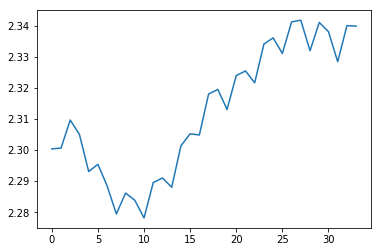

Errors in run 1: [2.4712637562778306, 2.4943481979841224, 2.508915476414862, 2.509447042186423, 2.5047333650665737, 2.510143468049303, 2.507186736049472, 2.50340611477911, 2.508041393920803, 2.505501753046596, 2.501823428660178, 2.5094310227538417, 2.5115838892211215, 2.510841537039668, 2.522322911793664, 2.5290552346970503, 2.528728746823708, 2.539854409766353, 2.544627781675058, 2.5425285069115136, 2.5502120844757585, 2.552205474630737, 2.5507577455738235, 2.5594054704369245, 2.561789097234132, 2.55833458365106, 2.5647251681361425, 2.5659514781833233, 2.559289929681684, 2.5610797835146615, 2.559371366917681, 2.5537475148601767, 2.5590335066260392, 2.5621006266506456]


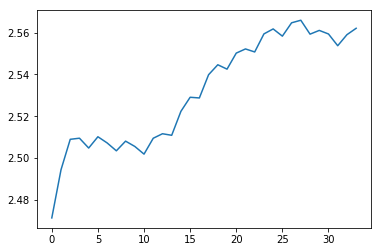

Errors in run 2: [2.1932131309950837, 2.214303577307755, 2.225575915778205, 2.2275198715201814, 2.230764928533725, 2.2332829834629444, 2.233418588746626, 2.2354790489213716, 2.239687863756923, 2.2393474333325525, 2.2392282423171155, 2.2456972558411645, 2.2515854472660948, 2.250817071126197, 2.255541745357667, 2.2611175594012862, 2.2605266681554714, 2.2653700347579746, 2.272217425661884, 2.2724800218860732, 2.278094856436418, 2.2843066556656058, 2.284296252316578, 2.290311021868481, 2.2921228804218097, 2.2935959151079244, 2.2996616088414332, 2.300393170573296, 2.299608076478045, 2.3049074006276853, 2.30618683237192, 2.308691164565824, 2.31809379427096, 2.3196378293534434]


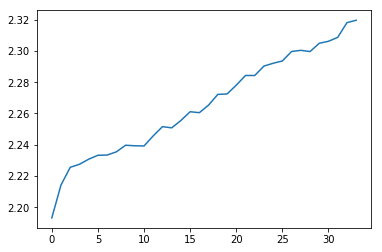

In [20]:
for run_idx in range(3):
    error_per_lead = []
    for lead in range(len(errors_per_run[0])):
        error_per_lead += [np.sqrt(np.nanmean(np.square(errors_per_run[run_idx][lead])))]

    print('Errors in run %s: %s' % (run_idx, error_per_lead))
    plt.plot(error_per_lead)
    plt.show()

### Run times
16 Processes, 16 Data Splits: 314.79163932800293s |
8 Processes, 16 Data Splits: 330s |
8 Processes, 8 Data Splits: 183.3667459487915s |